In [32]:
import opendatasets as od
import os

from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T
import torch
import torch.nn as nn
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
dataset_url = 'https://www.kaggle.com/splcher/animefacedataset'
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username:

  loveplay1983


Your Kaggle Key:

  ········


100%|██████████████████████████████████████████████████████████████████| 395M/395M [04:00<00:00, 1.72MB/s]


In [5]:
DATA_DIR = "./animefacedataset/"
print(os.listdir(DATA_DIR))

['images']


In [6]:
print(os.listdir(DATA_DIR+"/images")[:10])

['62117_2019.jpg', '31579_2010.jpg', '9722_2004.jpg', '20476_2007.jpg', '4278_2002.jpg', '27515_2009.jpg', '46277_2014.jpg', '60708_2018.jpg', '44610_2013.jpg', '34056_2011.jpg']


In [9]:
img_size = 64
batch_size = 128
stats= (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)


In [10]:
train_ds = ImageFolder(DATA_DIR, transform=T.Compose([
    T.Resize(img_size),
    T.CenterCrop(img_size),
    T.ToTensor(),
    T.Normalize(*stats)
]))

In [11]:
train_dl = DataLoader(train_ds, batch_size, 
                      shuffle=True, num_workers=3,
                      pin_memory=True
)

In [15]:
stats[1][0]

0.5

In [16]:
stats[0][0]

0.5

In [17]:
def denorm(img_tensors):
    # target * std + mean 
    return img_tensors * stats[1][0] + stats[0][0]

In [25]:
def show_images(imgs, nmax=64):
    fig, ax = plt.subplots(figsize=(6,8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(imgs.detach()[:nmax]), nrow=8).permute(1,2,0))

def show_batch(dl, nmax=64):
    for imgs, _ in dl:
        show_images(imgs, nmax)
        break

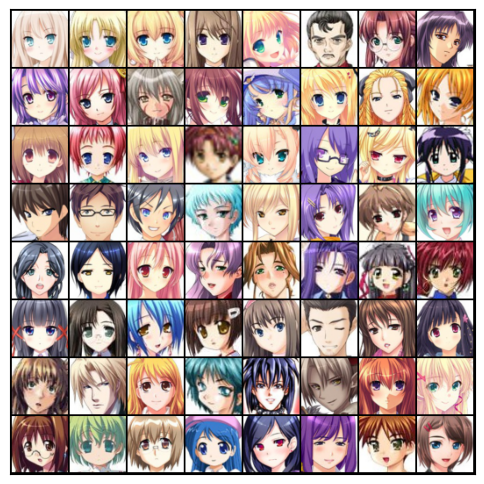

In [26]:
show_batch(train_dl)

In [29]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device("cuda")
    else:
        return torch.device("cpu")

def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device=device

    def __iter__(self):
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)


In [30]:
device  = get_default_device()
device

device(type='cuda')

In [31]:
train_dl = DeviceDataLoader(train_dl, device)

In [34]:
discriminator = nn.Sequential(
    # input: 3x64x64
    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(.2, inplace=True),
    # output: 64x32x32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(.2, inplace=True),
    # out: 128x16x16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(.2, inplace=True),
    # out: 256x8x8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1
    
    nn.Flatten(),
    nn.Sigmoid()
)

In [35]:
discriminator = to_device(discriminator, device)

# Generator network

The input to the generator is typically a vector or a matrix of random numbers (referred to as a latent tensor) which is used as a seed for generating an image. The generator will convert a latent tensor of shape `(128, 1, 1)` into an image tensor of shape `3 x 28 x 28`. To achive this, we'll use the `ConvTranspose2d` layer from PyTorch, which is performs to as a *transposed convolution* (also referred to as a *deconvolution*). [Learn more](https://github.com/vdumoulin/conv_arithmetic/blob/master/README.md#transposed-convolution-animations)

![](https://i.imgur.com/DRvK546.gif)

___

In GANs, the generator typically uses ConvTranspose2d (or deconvolution) layers to upsample the initially generated low-resolution image with fewer pixels but higher channel dimensions. The deconvolution layers help in increasing the spatial dimensions of the image while maintaining the channel information.

The generator learns to generate more realistic images by progressively refining the initially generated low-resolution image based on the feedback from the discriminator. The discriminator evaluates the generated image and provides feedback on its authenticity. The generator then adjusts its parameters, including the deconvolution layers, to improve the quality of the generated image, aligning it more closely with the target distribution.

During the training process, the generator gradually learns to generate images with higher resolution, more accurate features, and better alignment with the target distribution. The number of channels and the spatial dimensions of the image are adjusted accordingly through the deconvolution layers, allowing the generator to generate more complex and realistic images.

In [36]:
latent_size = 128